In [7]:
%run ../scripts/lab3_analysis_functions.py

In [8]:
filename = '../data/longCs.h5'
hf = tables.open_file(filename, "r")
raw_data_1 = import_data(filename)
event_data_cs1= hf.root.EventData.read()
hf.close()

In [9]:
# filename = '/Users/Asia/Desktop/204/lab3/lab3/data/am1.h5'
# hf = tables.open_file(filename, "r")
# raw_data_1 = import_data(filename)
# event_data_am1= hf.root.EventData.read()
# hf.close()

# filename = '/Users/Asia/Desktop/204/lab3/lab3/data/am2.h5'
# hf = tables.open_file(filename, "r")
# raw_data_2 = import_data(filename)
# event_data_am2= hf.root.EventData.read()
# hf.close()

# filename = '/Users/Asia/Desktop/204/lab3/lab3/data/cs1.h5'
# hf = tables.open_file(filename, "r")
# raw_data_1 = import_data(filename)
# event_data_cs1= hf.root.EventData.read()
# hf.close()

# filename = '/Users/Asia/Desktop/204/lab3/lab3/data/cs2.h5'
# hf = tables.open_file(filename, "r")
# raw_data_2 = import_data(filename)
# event_data_cs2= hf.root.EventData.read()
# hf.close()

In [10]:
# event_data_am = np.concatenate((event_data_am1, event_data_am2))
# event_data_cs = np.concatenate((event_data_cs1, event_data_cs2))

In [12]:
# sort events by timestamp
event_data_cs1 = event_data_cs1[np.argsort(event_data_cs1['timestamp'])]

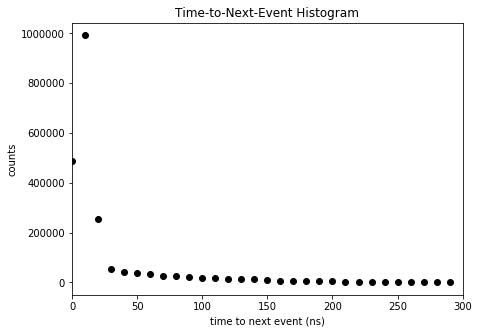

In [93]:
time_btwn_events = np.diff(event_data_cs1['timestamp'])
counts, bin_edges = np.histogram(time_btwn_events, bins=30, range = [0, 30])
bins = (bin_edges[1:]+bin_edges[:-1])/2 # bin centers from bin edges
for i in range(0, len(bins), 1):
    bins[i] = i*10
plt.figure(4, figsize=(7, 5))
plt.cla()
plt.clf()
plt.plot(bins, counts, 'ko')
plt.xlabel('time to next event (ns)')
plt.ylabel('counts')
plt.title("Time-to-Next-Event Histogram")
plt.xlim([0, 300])
plt.savefig("../figures/time-to-next-event.pdf")
plt.show()

In [14]:
print('applying energy calibration to data files...')
print('(this part takes a bit of time)')

filename = '../data/calibration.txt'
calibration = np.genfromtxt(filename,delimiter=' ')
slopes = calibration[:,0]
intercepts = calibration[:,1]

for i in range(0, 152, 1):
    mask = (event_data_cs1['detector'] == i)
    event_data_cs1['ADC_value'][mask] = calculate_energies(event_data_cs1['ADC_value'][mask], slopes[i], intercepts[i])
    if i == 90:
        print('still going... almost done')
    if i == 152:
        print('phew! done with that part')
    

applying energy calibration to data files...
(this part takes a bit of time)
still going... almost done


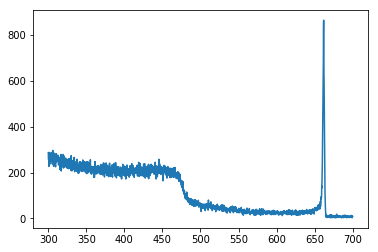

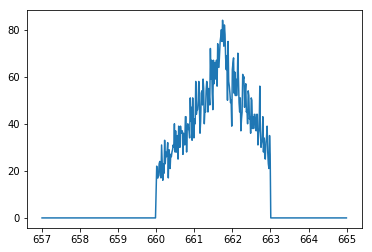

In [15]:
counts, bin_edges = np.histogram(event_data_cs1['ADC_value'], bins=2048, range = [300, 700])
bins = (bin_edges[1:]+bin_edges[:-1])/2 # bin centers from bin edges

plt.plot(bins, counts)
plt.savefig('../figures/energy-spectrum.pdf')
plt.show()


mask_1 = ((660 < event_data_cs1['ADC_value']) & (event_data_cs1['ADC_value'] < 663))
counts, bin_edges = np.histogram(event_data_cs1['ADC_value'][mask_1], bins=500, range = [657, 665])
bins = (bin_edges[1:]+bin_edges[:-1])/2 # bin centers from bin edges

plt.plot(bins, counts)
plt.savefig('../figures/energy-spectrum-cut.pdf')
plt.show()

In [19]:
import h5py

In [35]:
print(len(raw_data_1))
print(len(event_data_cs1))
print(len(event_data_cs1[mask_1]))

2559802
2559802
8317


In [45]:
# baseline correct raw pulses
raw_data_1 = fast_baseline_correction(raw_data_1)

In [48]:
def make_test_file(masked_data, rawdata):
    f = open('test.csv', 'w')
    for i in event_data_cs1[mask_1]:
        #print(i)
        f.write(str(i[0]) +','+ str(i[1]) + ','+str(i[2]) + ','+ str(i[3]) + ','+ str(i[4]) + ','+ str(i[5]) + ','+ str(i[6]) + '\n')
    f.close()

    f = open('test_trace.csv', 'w')
    for i in event_data_cs1['rid'][mask_1]:
        x = rawdata[i]
        for j in x:
            f.write(str(j) + ' ')
        f.write('\n')
    f.close()

#make_test_file(event_data_cs1[mask_1], raw_data_1)

In [49]:
# full energy only
mask_1 = ((640 < event_data_cs1['ADC_value']) & (event_data_cs1['ADC_value'] < 680))
print(event_data_cs1['ADC_value'][mask_1][0:10])

[ 677.69152832  658.96270752  660.75109863  662.43505859  661.61340332
  658.53735352  662.78399658  648.70495605  663.44604492  676.03094482]


In [38]:
#dc1, dc2, ac1, ac2
face1 = np.arange(0, 38) # dc1 
face2 = np.arange(38, 76) # dc2
face3 = np.arange(76, 114) # ac1
face4 = np.arange(114, 152) # ac2

In [103]:
def calculate_t50(signal, plot=False):
    signal = signal[:-100]
    x = np.linspace(0, len(signal) -100, len(signal) -99)
   # print(x)
    sig = savgol_filter(signal, 15, 3) # window size 51, polynomial order 3

    if sig.all() == 0:
        return -1000
    elif np.argmax(sig) == len(sig):
        return -1000
    else:
        maxval = np.amax(sig)
        fiftyval = maxval* 0.5
        fiftyindex = 0
        for i in range(0, len(sig), 1):
            if sig[i] <= fiftyval:
                fiftyindex = i

        if (fiftyindex + 3) >= len(sig):
            x_fit_low = np.linspace((fiftyindex - 2), len(sig), len(sig)-2 - fiftyindex)
            sig_fit_low = sig[int(fiftyindex - 2): len(sig)]          
        else:
            x_fit_low = np.linspace((fiftyindex - 2), int(fiftyindex + 3), 5)
            sig_fit_low = sig[int(fiftyindex - 2): int(fiftyindex + 3)]
        if len(x_fit_low) != len(sig_fit_low):
            print(fiftyindex)
            print(len(x_fit_low))
            print(len(sig_fit_low))
            print(x_fit_low)
            print(sig_fit_low)
            plt.plot(signal)
            plt.plot(sig)
            plt.show()
            plt.plot(signal[int(fiftyindex - 4):int(fiftyindex + 5)], 'o')
            plt.plot(sig[int(fiftyindex -4): int(fiftyindex + 5)], 'o')
            plt.show()
            x_fit_low = x_fit_low = np.linspace((fiftyindex - 1), int(fiftyindex + 2), 4)
            sig_fit_low = sig[int(fiftyindex -1): int(fiftyindex +2)]
            print(len(x_fit_low))
            print(len(sig_fit_low))
        x_fit_low = np.array(x_fit_low)
        sig_fit_low = np.array(sig_fit_low)
        if len(x_fit_low) < 1:
            print('x empty')
            plt.plot(signal)
            plt.plot(sig)
            plt.show()
            return -1000
        else:
            m, b = np.polyfit(x_fit_low, sig_fit_low, deg=1)
            fit_low = b + m * x_fit_low
            rise_low = ((fiftyval - b )/ m)

        t50 = (rise_low) * 10# ns

        if plot==True:
            plt.figure(figsize=(10,5))
            plt.plot(signal, '-', label = 'raw signal')
            plt.plot(sig, label = 'smoothed signal')
            plt.plot(x_fit_low, fit_low,'-', linewidth = 5.0,alpha=0.7, label = 'fit')
            plt.plot(t50/10, fiftyval, 'ro', label='t50')
            plt.title('T50 Fitting')
            plt.ylabel('ADC value')
            plt.xlabel('ADC sample (10 ns sampling time)')
            plt.legend()
            #plt.savefig('t50_fitting.pdf')
            plt.show()
        return t50

In [104]:
#x = 7000
diff1vals = []
flag = 0 # 1 = detector1, 2= detector2, 3=detector1 neighbors, 4=detector2 neigbors, 5=other
delta_t50_values_1 = []
delta_t50_values_2 = []
for t in range(0, len(event_data_cs1['timestamp'][mask_1]), 1):
#for t in range(0, x, 1):
    diff0 = np.abs(event_data_cs1['timestamp'][mask_1][t] - event_data_cs1['timestamp'][mask_1][t-1])
    diff1 = np.abs(event_data_cs1['timestamp'][mask_1][t] - event_data_cs1['timestamp'][mask_1][t-2])
    # diff2 = np.abs(event_data_cs1['timestamp'][mask_1][t+1] - event_data_cs1['timestamp'][mask_1][t])
    # diff3 = np.abs(event_data_cs1['timestamp'][mask_1][t+2] - event_data_cs1['timestamp'][mask_1][t])
    if diff0 < 50 and diff1 > 50:
        # print('0', diff0)
        # print('1', diff1)
        # print('2', diff2)
        # print('3', diff3)
        detector1 = (event_data_cs1['detector'][mask_1][t-1])
        detector2 = (event_data_cs1['detector'][mask_1][t])
        #print('-------------')
        
        if detector1 in face1 and detector2 in face1:
            # print('face1 neighbors')
            flag = 3
        elif detector1 in face2 and detector2 in face2:
            # print('face2 neighbors')
            flag = 3
        elif detector1 in face3 and detector2 in face3:
            # print('face3 neighbors')
            flag = 4
        elif detector1 in face4 and detector2 in face4:
            # print('face4 neighbors')
            flag = 4
            
        elif detector1 in face1 and detector2 in face3:
            # print('detector1')
            flag  = 1
        elif detector1 in face3 and detector2 in face1:
            # print('detector1')
            flag  = 1
        elif detector1 in face2 and detector2 in face4:
            # print('detector2')
            flag  = 2
        elif detector1 in face4 and detector2 in face2:
            # print('detector2')
            flag  = 2
        else:
            flag= 5
            # print('other')
            
        if flag == 1:
            rid1 = (event_data_cs1['rid'][mask_1][t-1])
            rid2 = (event_data_cs1['rid'][mask_1][t])
            adc1 = (event_data_cs1['ADC_value'][mask_1][t-1])
            adc2 = (event_data_cs1['ADC_value'][mask_1][t])

            t501 = calculate_t50(raw_data_1[rid1], plot=False)
            t502 = calculate_t50(raw_data_1[rid2], plot=False)
            if rid1 > rid2: # electrons - holes = ac - dc
                #deltat50 = -(diff0 * 10) - t502 + t501 #- diff0 * 10
                deltat50 = (diff0 * 10) + t502 - t501
            else:  # rid1 < rid2
                #deltat50 = (diff0 * 10) + t502 - t501 #- diff0 * 10 
                deltat50 = -(diff0 * 10) - t502 + t501
            deltat50 = round(float(deltat50),4)
            delta_t50_values_1.append(deltat50)
            diff1vals.append(diff0) 
                    
        elif flag == 2:
            rid1 = (event_data_cs1['rid'][mask_1][t-1])
            rid2 = (event_data_cs1['rid'][mask_1][t])
            adc1 = (event_data_cs1['ADC_value'][mask_1][t-1])
            adc2 = (event_data_cs1['ADC_value'][mask_1][t])
            t501 = calculate_t50(raw_data_1[rid1], plot=False)
            t502 = calculate_t50(raw_data_1[rid2], plot=False)
            
            if rid1 > rid2: # electrons - holes = ac - dc
                #deltat50 = -(diff0 * 10) - t502 + t501 #- diff0 * 10
                deltat50 = (diff0 * 10) + t502 - t501
            else:  # rid1 < rid2
                #deltat50 = (diff0 * 10) + t502 - t501 #- diff0 * 10 
                deltat50 = -(diff0 * 10) - t502 + t501

            deltat50 = round(float(deltat50),4)
            delta_t50_values_2.append(deltat50)
            diff1vals.append(diff0) 
        else:
            continue

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: overflow encountered in ulong_scalars
  


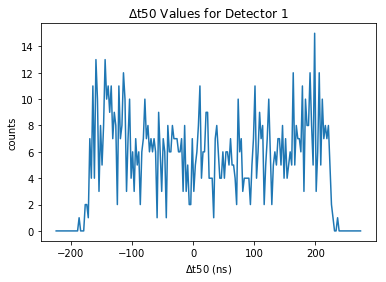

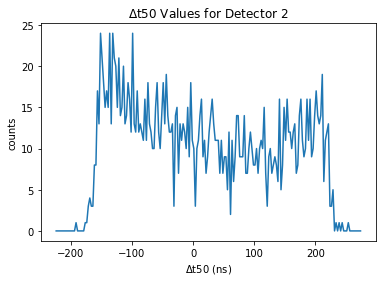

In [170]:
#print(len(delta_t50_values_1))
#print(len(delta_t50_values_2))
delta_t50_1 = np.asarray(delta_t50_values_1)#, dtype=float)
#print(type(delta_t50_1))
counts_det1, bin_edges = np.histogram(delta_t50_1, bins=200, range = [-225, 275])
bins_det1 = (bin_edges[1:]+bin_edges[:-1])/2 # bin centers from bin edges

plt.cla()
plt.clf()
#plt.axvline(-160,color='k')
#plt.axvline(210,color='k')
plt.plot(bins_det1, counts_det1)
plt.title('$\Delta$t50 Values for Detector 1')
plt.ylabel('counts')
plt.xlabel('$\Delta$t50 (ns)')
plt.savefig('../figures/t50s_det1.pdf')
plt.show()

delta_t50_2 = np.asarray(delta_t50_values_2)#, dtype=float)
#print(type(delta_t50_1))
counts_det2, bin_edges = np.histogram(delta_t50_2, bins=200, range = [-225, 275])
bins_det2 = (bin_edges[1:]+bin_edges[:-1])/2 # bin centers from bin edges

plt.cla()
plt.clf()
#plt.axvline(-160,color='k')
#plt.axvline(210,color='k')
plt.plot(bins_det2, counts_det2)
plt.title('$\Delta$t50 Values for Detector 2')
plt.ylabel('counts')
plt.xlabel('$\Delta$t50 (ns)')
plt.savefig('../figures/t50s_det2.pdf')
plt.show()

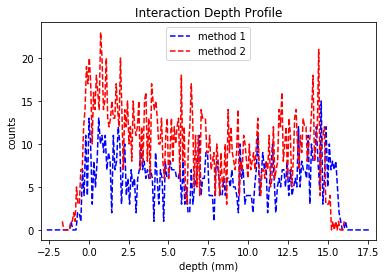

In [177]:
# method 1 = linear fit
x = (np.linspace(0, 15, len(cut_bins_det1)))
m, b = np.polyfit(cut_bins_det1, x, deg=1)
x_values = b + m * bins_det1
y_values = counts_det1
plt.xlim([-3,18])
plt.plot(x_values, y_values,'b--', label='method 1')
#plt.show()

# method 2 
z_0 = 5.2  # mm
z_0 = 5.2 + 0.75# mm
k_c = 0.04  # mm/ns
c = 3*10**8 # m/s
c = 299.792 # mm/ns
z_coord_eq_1 = []
#print(len(delta_t50_values_2))
for i in delta_t50_values_2:
    z = z_0 + 0.04*(i)
    z_coord_eq_1.append(z)
    
z_coord_eq_1= np.asarray(z_coord_eq_1)#, dtype=float)
#print(type(delta_t50_1))
z_coord_eq_1_y, bin_edges = np.histogram(z_coord_eq_1, bins=200)
z_coord_eq_1_x = (bin_edges[1:]+bin_edges[:-1])/2 # bin centers from bin edges

plt.plot(z_coord_eq_1_x, z_coord_eq_1_y,'r--', label = 'method 2')
plt.xlim([-3,18])
plt.title('Interaction Depth Profile')
plt.xlabel('depth (mm)')
plt.ylabel('counts')
plt.legend()
plt.savefig('../figures/interactiondepths.pdf')
plt.show()

1909
1909


/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log
  


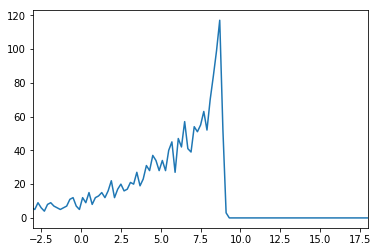

In [178]:

# method 3
z_coord_eq_2 = []
a= -140.7  #ns
b=301.8  #mm
c=0.3075  #mm^-1
d=5.033  #mm


print(len(delta_t50_values_2))
for i in delta_t50_values_2:
    #i = np.abs(i)
    i = -i
    l = np.log(b/(-i - a)) 
    z = d - ((l-1)/c)
    z_coord_eq_2.append(z)

print(len( z_coord_eq_2))
z_coord_eq_2= np.asarray(z_coord_eq_2)#, dtype=float)
#print(type(delta_t50_1))
z_coord_eq_2_y, bin_edges = np.histogram(z_coord_eq_2, bins=200, range =[-20, 20])
z_coord_eq_2_x = (bin_edges[1:]+bin_edges[:-1])/2 # bisn centers from bin edges
plt.plot(z_coord_eq_2_x, z_coord_eq_2_y)
plt.xlim([-3,18])
plt.show()

[[Model]]
    Model(exponential, prefix='exp_')
[[Fit Statistics]]
    # function evals   = 12
    # data points      = 200
    # variables        = 2
    chi-square         = 979.420
    reduced chi-square = 4.947
    Akaike info crit   = 321.729
    Bayesian info crit = 328.325
[[Variables]]
    exp_amplitude:   4.73000011 +/- 0.161421 (3.41%) (init= 3.491244)
    exp_decay:      -2.1430e+09 +/- 1.74e+14 (8096944.95%) (init=-321401)
[[Correlations]] (unreported correlations are <  0.100)
    C(exp_amplitude, exp_decay)  = -0.225 



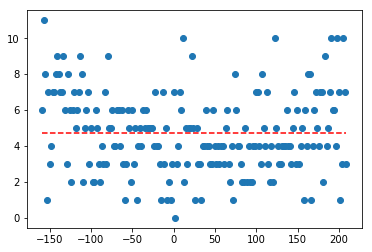

[[Model]]
    Model(exponential, prefix='exp_')
[[Fit Statistics]]
    # function evals   = 15
    # data points      = 200
    # variables        = 2
    chi-square         = 1927.951
    reduced chi-square = 9.737
    Akaike info crit   = 457.179
    Bayesian info crit = 463.776
[[Variables]]
    exp_amplitude:   9.26546348 +/- 0.224427 (2.42%) (init= 8.638807)
    exp_decay:       607.560710 +/- 86.22427 (14.19%) (init= 700.3582)
[[Correlations]] (unreported correlations are <  0.100)
    C(exp_amplitude, exp_decay)  =  0.113 



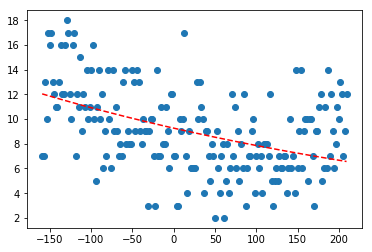

607.56071007540652

In [171]:
def fit_exponential(x, y):
    exp = lmfit.models.ExponentialModel(prefix='exp_')
    pars = exp.guess(y, x=x)
    mod = exp
    init = mod.eval(pars, x=x)
    out = mod.fit(y, pars, x=x)
    return out.params

def fit_exponential_with_plot(x, y):
    exp = lmfit.models.ExponentialModel(prefix='exp_')
    pars = exp.guess(y, x=x)
    mod = exp
    init = mod.eval(pars, x=x)
    out = mod.fit(y, pars, x=x)
    print(out.fit_report())
    plt.figure()
    plt.plot(x, y, 'o')
    plt.plot(x, out.best_fit, 'r--')
    plt.show()
    return out.params

def get_tau_exponential(x, y):
    tau_values = []
    out = fit_exponential_with_plot(x, y)
    if out['exp_decay'].value < 1e4 and out['exp_decay'].stderr < 100:
        tau_values.append(out['exp_decay'].value)
    tau = np.mean(tau_values)
    return tau

cut_counts_det1, bin_edges = np.histogram(delta_t50_1, bins=200, range = [-160, 210])
cut_bins_det1 = (bin_edges[1:]+bin_edges[:-1])/2 # bin centers from bin edges

cut_counts_det2, bin_edges = np.histogram(delta_t50_2, bins=200, range=[-160, 210])
cut_bins_det2 = (bin_edges[1:]+bin_edges[:-1])/2 # bin centers from bin edges

get_tau_exponential(cut_bins_det1, cut_counts_det1)
get_tau_exponential(cut_bins_det2, cut_counts_det2)